In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import uncertainties
import numpy as np
import scipy.stats
from cycler import cycler
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import itertools

FLUX_DATA_SOURCE = "gerosa"
#FLUX_DATA_SOURCE = "davidi"


color_palettes = ["bright", "Set2", "Set3", "Purples", "Greens", "Greys", "Blues", "Reds", "Oranges"]
COLORS = list(itertools.chain(*map(sns.color_palette, color_palettes)))

In [2]:
def eval_Km(value):
    if pd.isnull(value):
        return np.nan
    Km = eval(value)
    if type(Km) == list:
        return scipy.stats.gmean(Km)
    else:
        return float(Km)

kinetics_df = pd.read_csv('data/enzyme_kinetics.csv', index_col=0)
kinetics_df["Km_uM"] = kinetics_df.Km_uM.apply(eval_Km)
kinetics_df.sample(5)

,gene,cycling_pool,kcat_1_per_sec,compilation,literature for kcat,Km_uM,Km_metabolite
reaction,,,,,,,
GAPD,gapA,NAD + NADH,268.0,Davidi et al,PMID:10190977,890.000000,C00118
DTMPK,tmk,AMP + ADP + ATP,9.6,Davidi et al,PMID:13967158,60.000000,C00364
ADSK,cysC,AMP + ADP + ATP,50.0,Davidi et al,PMID:2549047,0.353553,C00224
MTHFR2,metF,NAD + NADH,10.0,Davidi et al,PMID:11371182,85.000000,C00143
PTPATi,coaD,AMP + ADP + ATP,19.0,Davidi et al,PMID:8448160,4.700000,C01134


In [3]:
protein_df = pd.read_csv('data/protein_abundance_mmol_per_gCDW.csv', index_col=0)
protein_df = protein_df.reset_index().melt(id_vars=["reaction", "gene"], var_name="condition", value_name="protein_abundance_mmol_per_gCDW")
protein_df.sample(5)

,reaction,gene,condition,protein_abundance_mmol_per_gCDW
106,DHFS,folC,galactose,3.600000e-07
112,MTHFR2,metF,galactose,5.200000e-06
126,PRFGS,purL,galactose,3.700000e-06
97,AKGDH,"lpd,sucA,sucB",galactose,NaN
241,DHFS,folC,pyruvate,9.500000e-07


In [4]:
metabolite_df = pd.read_csv('data/metabolite_concentration_umol_per_gCDW.csv', index_col=(0,1))
metabolite_df = metabolite_df.applymap(lambda x: uncertainties.ufloat_fromstr(x) if type(x)==str else np.nan)
metabolite_df = metabolite_df.reset_index().melt(id_vars=["metabolite", "KEGG_ID"], var_name="condition", value_name="metabolite_concentration_umol_per_gCDW")
metabolite_df.sample(5)

,metabolite,KEGG_ID,condition,metabolite_concentration_umol_per_gCDW
122,NADPH,C00005,pyruvate,0.133+/-0.008
135,NADP + NADPH,NaN,succinate,0.210+/-0.020
93,6PGC,C00345,glycerol,0.064+/-0.031
79,ATP,C00002,glycerol,4.77+/-0.23
111,PYR,C00022,gluconate,1.6+/-0.6


In [5]:
if FLUX_DATA_SOURCE == "davidi":
    flux_df = pd.read_csv('data/flux_mmol_per_gCDW_s_davidi.csv', index_col=0)
    flux_df = flux_df.reset_index().melt(id_vars="reaction", var_name="condition", value_name="flux_mmol_per_gCDW_sec")
elif FLUX_DATA_SOURCE == "gerosa":
    flux_df = pd.read_csv('data/flux_mmol_per_gCDW_h_gerosa.csv', index_col=0)
    flux_df = flux_df.applymap(lambda x: uncertainties.ufloat_fromstr(x) if type(x)==str else np.nan)
    flux_df = flux_df.reset_index().melt(id_vars="reaction", var_name="condition", value_name="flux_mmol_per_gCDW_h")
    flux_df["flux_mmol_per_gCDW_sec"] = flux_df.flux_mmol_per_gCDW_h.apply(lambda x: x.nominal_value) / 3600.0
flux_df.sample(5)

,reaction,condition,flux_mmol_per_gCDW_h,flux_mmol_per_gCDW_sec
332,Glc_Ex,succinate,0.0+/-0,0.000000
6,Pyr_Ex,acetate,0.0+/-0,0.000000
47,Ace_Ex,fructose,-3.33+/-0.06,-0.000925
292,PGI,pyruvate,-0.90+/-0.07,-0.000249
127,PPCK,galactose,0.849+/-0.033,0.000236


In [6]:
# join the kcat upper bound with the flux data
# calculate the flux upper bound based on abundance and kcat
# the resulting units are mmol_per_gCDW x 1_per_sec = mmol_per_gCDW_sec

kcat_ub = protein_df.join(kinetics_df.drop("gene", axis="columns"), on="reaction")
kcat_ub["kcat_x_adunbance_mmol_per_gCDW_sec"] = kcat_ub.kcat_1_per_sec * kcat_ub.protein_abundance_mmol_per_gCDW
joined_df = pd.merge(kcat_ub, flux_df, on=["reaction", "condition"], how="inner")
joined_df["kapp_1_per_sec"] = joined_df.flux_mmol_per_gCDW_sec / joined_df.protein_abundance_mmol_per_gCDW
joined_df.rename(columns={"Km_metabolite": "KEGG_ID"}, inplace=True)

In [7]:
# calculate the saturation level of the non-cycling substrate
joined_df = pd.merge(joined_df, metabolite_df[["KEGG_ID", "metabolite", "condition", "metabolite_concentration_umol_per_gCDW"]], on=["KEGG_ID", "condition"], how="left")

CELL_DENSITY = 1.1e3 # gr/L
CELL_DRY_FRACTION = 0.3 # gCDW/gr
CELL_DRY_DENSITY = CELL_DRY_FRACTION * CELL_DENSITY # (gr/L) * (gCDW/gr) = gCDW/L

joined_df["Km_umol_per_gCDW"] = joined_df.Km_uM / CELL_DRY_DENSITY  # (μmol/L) / (gCDW/L) = μmol/gCDW

# we need to convert uM into mmol/gCDW for the Km values first
joined_df["saturation"] = joined_df.metabolite_concentration_umol_per_gCDW / (joined_df.metabolite_concentration_umol_per_gCDW + joined_df.Km_umol_per_gCDW)

In [8]:
# Add the data about the total concentration of the cycling (cofactor) pools
cycling_pools = joined_df[["cycling_pool"]].drop_duplicates()
cycling_pools["metabolites"] = cycling_pools.cycling_pool.str.findall("[^\s^+]+")
cycling_pools = cycling_pools.explode("metabolites").set_index("metabolites")

cycling_pool_df = metabolite_df.join(cycling_pools, on="metabolite", how="right").groupby(["condition", "cycling_pool"]).metabolite_concentration_umol_per_gCDW.sum().reset_index()
cycling_pool_df.rename(columns={"metabolite_concentration_umol_per_gCDW": "cofactor_concentration_umol_per_gCDW"}, inplace=True)
joined_df = pd.merge(joined_df, cycling_pool_df, on=["condition", "cycling_pool"])

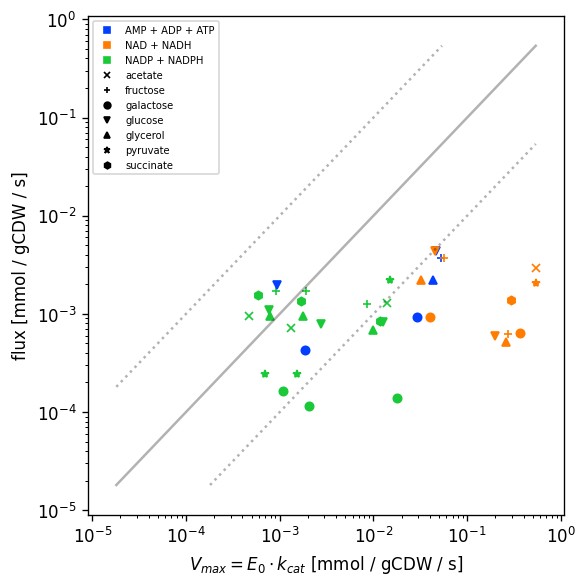

In [9]:
fig1, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=120, sharey=True)

conditions = sorted(joined_df.condition.unique())
markers = ["x", "+", "o", "v", "^", "*", "h"]
condition2marker = dict(zip(conditions, markers))

cycling_pools = sorted(joined_df.cycling_pool.unique())
cycling_pool2color = dict(zip(cycling_pools, COLORS))
reaction2cycling_pool = kinetics_df.cycling_pool
reaction2color = {r:cycling_pool2color[reaction2cycling_pool[r]] for r in kinetics_df.index}

_df = joined_df[joined_df.flux_mmol_per_gCDW_sec > 0]
_df.insert(0, "x", _df.kcat_x_adunbance_mmol_per_gCDW_sec)
_df.insert(1, "y", _df.flux_mmol_per_gCDW_sec)

for row in _df.itertuples():
    marker = condition2marker[row.condition]
    color = reaction2color[row.reaction]
    ax.plot(row.x, row.y, marker=marker, markersize=5, color=color, alpha=1)

vmin = min(_df.x.min(), _df.y.min())
vmax = max(_df.x.max(), _df.y.max())
ax.plot([vmin, vmax], [vmin, vmax], "k-", alpha=0.3, label="upper bound")
ax.plot([vmin, vmax/10], [vmin*10, vmax], "k:", alpha=0.3, label="x10 upper bound")
ax.plot([vmin*10, vmax], [vmin, vmax/10], "k:", alpha=0.3, label="x0.1 upper bound")
ax.set_xlim(vmin/2, vmax*2)
ax.set_ylim(vmin/2, vmax*2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$V_{max} = E_0 \cdot k_{cat}$ [mmol / gCDW / s]")
ax.set_ylabel("flux [mmol / gCDW / s]")

legend_elements = [
    Line2D([0], [0], color=cycling_pool2color[c], marker="s", linewidth=0, markersize=4) for c in cycling_pools
] + [
    Line2D([0], [0], color="k", marker=condition2marker[c], markersize=4, linewidth=0) for c in conditions
]
legend_labels = cycling_pools + conditions
ax.legend(legend_elements, legend_labels, fontsize=6)

fig1.tight_layout()

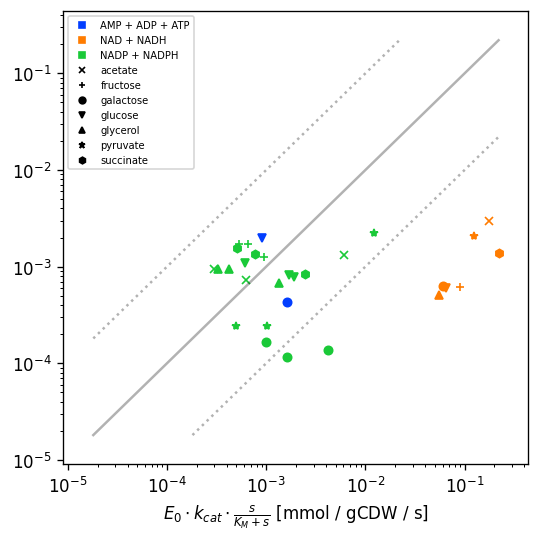

In [10]:
fig2, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=120, sharey=True)
saturation_df = joined_df[(~pd.isnull(joined_df.Km_uM)) & ~(pd.isnull(joined_df.metabolite_concentration_umol_per_gCDW))]

_df = joined_df[(joined_df.flux_mmol_per_gCDW_sec > 0) & (~pd.isnull(joined_df.saturation))]
_df.insert(0, "x", _df.saturation.apply(lambda x: x.nominal_value) * _df.kcat_x_adunbance_mmol_per_gCDW_sec)
_df.insert(1, "y", _df.flux_mmol_per_gCDW_sec)

for row in _df.itertuples():
    marker = condition2marker[row.condition]
    color = reaction2color[row.reaction]
    ax.plot(row.x, row.y, marker=marker, markersize=5, color=color, alpha=1)

ax.set_xlabel(r"$E_0 \cdot k_{cat} \cdot \frac{s}{K_M + s}$ [mmol / gCDW / s]")
vmin = min(_df.x.min(), _df.y.min())
vmax = max(_df.x.max(), _df.y.max())
ax.plot([vmin, vmax], [vmin, vmax], "k-", alpha=0.3, label="upper bound")
ax.plot([vmin, vmax/10], [vmin*10, vmax], "k:", alpha=0.3, label="x10 upper bound")
ax.plot([vmin*10, vmax], [vmin, vmax/10], "k:", alpha=0.3, label="x0.1 upper bound")
ax.set_xlim(vmin/2, vmax*2)
ax.set_ylim(vmin/2, vmax*2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(legend_elements, legend_labels, loc="upper left", fontsize=6);

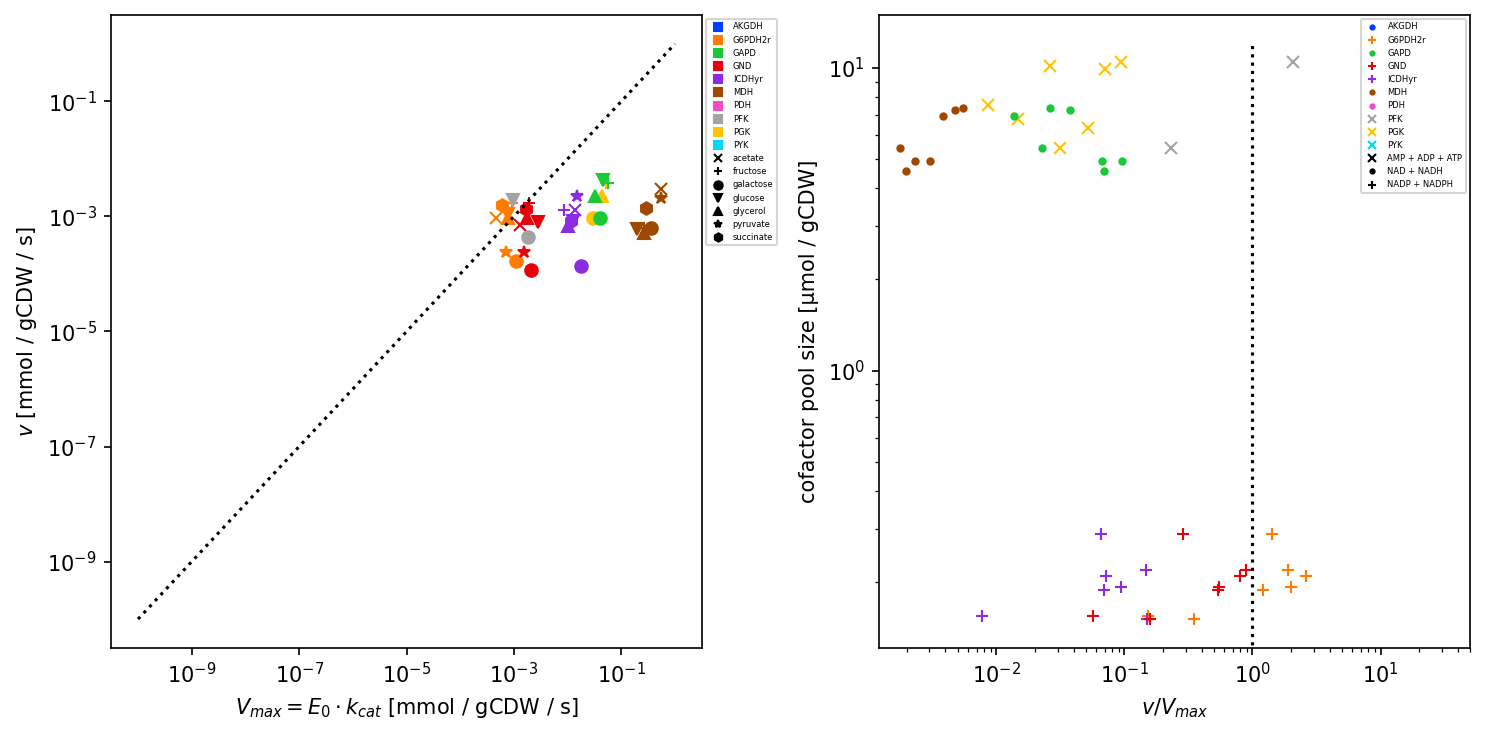

In [11]:
fig3, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=150, sharey=False)

conditions = sorted(joined_df.condition.unique())
markers = ["x", "+", "o", "v", "^", "*", "h"]
condition2marker = dict(zip(conditions, markers))

reactions = sorted(joined_df.reaction.unique())
reaction2color = dict(zip(reactions, COLORS))

ax = axs[0]
for row in joined_df.itertuples():
    marker = condition2marker[row.condition]
    color = reaction2color[row.reaction]
    ax.plot(row.kcat_x_adunbance_mmol_per_gCDW_sec, row.flux_mmol_per_gCDW_sec, marker=marker, color=color, alpha=1)
ax.plot([1e-10, 1], [1e-10, 1], "k:", label="upper bound")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$V_{max} = E_0 \cdot k_{cat}$ [mmol / gCDW / s]")
ax.set_ylabel("$v$ [mmol / gCDW / s]")

legend_elements = [
    Line2D([0], [0], color=reaction2color[r], marker="s", linewidth=0, markersize=4) for r in reactions
] + [
    Line2D([0], [0], color="k", marker=condition2marker[c], markersize=4, linewidth=0) for c in conditions
]
legend_labels = reactions + conditions
ax.legend(legend_elements, legend_labels, fontsize=4, bbox_to_anchor=(1,1))


# same plot with markers based on cycling compound rather than condition
cycling_pools = sorted(joined_df.cycling_pool.unique())
markers = ["x", ".", "+"]
cycling_pool2marker = dict(zip(cycling_pools, markers))
reaction2cycling_pool = kinetics_df.cycling_pool

reactions = sorted(joined_df.reaction.unique())
reaction2color = dict(zip(reactions, COLORS))

ax = axs[1]
for row in joined_df.itertuples():
    marker = cycling_pool2marker[row.cycling_pool]
    color = reaction2color[row.reaction]
    ax.plot(
        np.abs(row.flux_mmol_per_gCDW_sec / row.kcat_x_adunbance_mmol_per_gCDW_sec),
        row.cofactor_concentration_umol_per_gCDW.nominal_value,
        marker=marker,
        color=color,
        alpha=1
    )
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$v / V_{max}$")
ax.set_ylabel("cofactor pool size [μmol / gCDW]")
ax.set_xlim([None, 50])
ax.plot([1, 1], [0, 12], "k:")

legend_elements = [
    Line2D([0], [0], color=reaction2color[r], marker=cycling_pool2marker[reaction2cycling_pool[r]], linewidth=0, markersize=4) for r in reactions
] + [
    Line2D([0], [0], color="k", marker=cycling_pool2marker[c], markersize=4, linewidth=0) for c in cycling_pools
]
legend_labels = reactions + cycling_pools
ax.legend(legend_elements, legend_labels, fontsize=4, bbox_to_anchor=(1,1))
fig3.tight_layout()

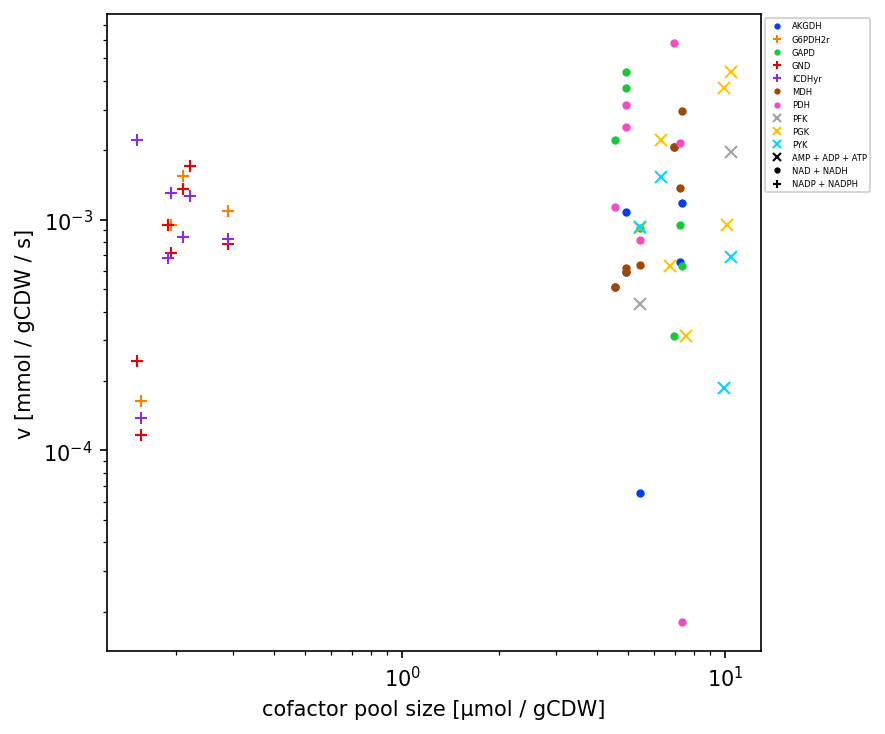

In [12]:
fig4, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=150)

reactions = sorted(joined_df.reaction.unique())
reaction2color = dict(zip(reactions, COLORS))

# same plot with markers based on cycling compound rather than condition
cycling_pools = sorted(joined_df.cycling_pool.unique())
markers = ["x", ".", "+"]
cycling_pool2marker = dict(zip(cycling_pools, markers))
reaction2cycling_pool = kinetics_df.cycling_pool

reactions = sorted(joined_df.reaction.unique())
reaction2color = dict(zip(reactions, COLORS))

for reaction, group_df in joined_df.groupby("reaction"):
    color = reaction2color[reaction]
    c = group_df.cycling_pool.iat[0]
    ax.plot(
        group_df.cofactor_concentration_umol_per_gCDW.apply(lambda x: x.nominal_value),
        group_df.flux_mmol_per_gCDW_sec.abs(),
        color=color,
        markersize=6,
        marker=cycling_pool2marker[c],
        linewidth=0
    )
ax.set_xlabel("cofactor pool size [μmol / gCDW]")
ax.set_xscale("log")

ax.set_ylabel("v [mmol / gCDW / s]")
ax.set_yscale("log")
#ax.set_ylim([0, 0.01])
#ax.plot([1, 1], [0, 12], "k:")

legend_elements = [
    Line2D([0], [0], color=reaction2color[r], marker=cycling_pool2marker[reaction2cycling_pool[r]], linewidth=0, markersize=4) for r in reactions
] + [
    Line2D([0], [0], color="k", marker=cycling_pool2marker[c], markersize=4, linewidth=0) for c in cycling_pools
]
legend_labels = reactions + cycling_pools
ax.legend(legend_elements, legend_labels, fontsize=4, bbox_to_anchor=(1,1))
fig4.tight_layout()

In [13]:
with PdfPages(f"{FLUX_DATA_SOURCE}.pdf") as pdf:
    pdf.savefig(fig1)
    pdf.savefig(fig2)
    pdf.savefig(fig3)
    pdf.savefig(fig4)    

In [14]:
with PdfPages(f"{FLUX_DATA_SOURCE}_per_enzyme.pdf") as pdf:
    for reaction, group_df in joined_df[joined_df.flux_mmol_per_gCDW_sec > 0].groupby("reaction"):
        fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=90)
        
        x = group_df.cofactor_concentration_umol_per_gCDW.apply(lambda x: x.nominal_value)
        y = group_df.flux_mmol_per_gCDW_sec
        ax.plot(
            x,
            y,
            markersize=6,
            marker="o",
            linewidth=0
        )
        title = f"{reaction}, co-factor = {group_df.cycling_pool.iat[0]}"
        if group_df.shape[0] > 3:
            pearson_result = scipy.stats.pearsonr(x, y)
            title += f"\nPearson $r^2$ = {pearson_result.statistic:.2f}, $p$ = {pearson_result.pvalue:.1g}"
        
        ax.set_title(title)
        ax.set_xlabel("cofactor pool size [μmol / gCDW]")
        ax.set_xlim([0, None])
        ax.set_ylabel("v [mmol / gCDW / s]")
        ax.set_ylim([0, None])
        fig.tight_layout()
        pdf.savefig(fig)
        plt.close(fig)